This notebook plots a t-SNE for the first 5000 samples CIFAR10 training set. ResNet50 w/ImageNet weights is used as a feature extractor.

In [1]:
from typing import Any, Dict, Sequence, Tuple
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm.auto import tqdm

Get ResNet50 ImageNet-weights features for the first 5000 training samples.

In [2]:
class SubsetDataset(Dataset):
    """Dataset wrapper that subsets the underlying dataset. """
    def __init__(self, to_subset: Dataset, num: int = 1000) -> None:
        """
        Args
            to_subset (Dataset): dataset to wrap
            num (int): number of samples in subset
        """
        self._data = to_subset
        self._num = num
        assert len(to_subset) >= num

    def __len__(self) -> int:
        return self._num

    def __getitem__(self, idx: int) -> Any:
        if idx >= self._num:
            raise IndexError(f'idx {idx} o.o.b. for {self._num}-len subset')
        return self._data[idx]

In [3]:
# 10% subset
cifar10_subset = SubsetDataset(
    to_subset=CIFAR10(
        root='C:/Users/chiwe/Data',
        train=True,
        transform=Compose([ToTensor(), Resize((224, 224))])
    ),
    num=5000
)

In [4]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to('cuda:0').eval()
feat_ext = create_feature_extractor(model, ['avgpool'])

# ResNet50 ImageNet-weights features
all_features, all_labels = [], []
loader = DataLoader(cifar10_subset, batch_size=32, shuffle=False)
with torch.no_grad():
    for imgs, labels in tqdm(loader, leave=False):
        features = feat_ext(imgs.to('cuda:0'))['avgpool'].squeeze()
        all_features.append(features.cpu())
        all_labels.append(labels)
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

  0%|          | 0/157 [00:00<?, ?it/s]

Plot t-SNE graph.

In [5]:
def gen_tsne_plot(
    data: np.ndarray,
    labels: Sequence[int] = None,
    color: str = 'k',
    cmap: str = 'tab10',
    tsne_kwargs: Dict = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Project a dataset with t-SNE algorithm and plot.

    Args:
        data (np.ndarray): dataset to plot (num_samples, num_features)
        labels (Sequence[int]): sample classification labels
        color (str): marker color if no labels given
        cmap (str): marker colormap if labels given
        tsne_kwargs (Dict): sklearn.manifold.TSNE settings

    Returns:
        Tuple[plt.Figure, plt.Axes]: plot handles
    """
    tsne_kwargs = {} if tsne_kwargs is None else tsne_kwargs
    scatter_kwargs = {
        's': 30,
        'c': color if labels is None else labels,
        'marker': '.',
        'cmap': None if labels is None else cmap
    }

    # project and plot
    proj = TSNE(**tsne_kwargs).fit_transform(data)
    fig, axes = plt.subplots()
    axes.grid()
    axes.scatter(*proj.T, **scatter_kwargs)
    fig.tight_layout()

    return fig, axes

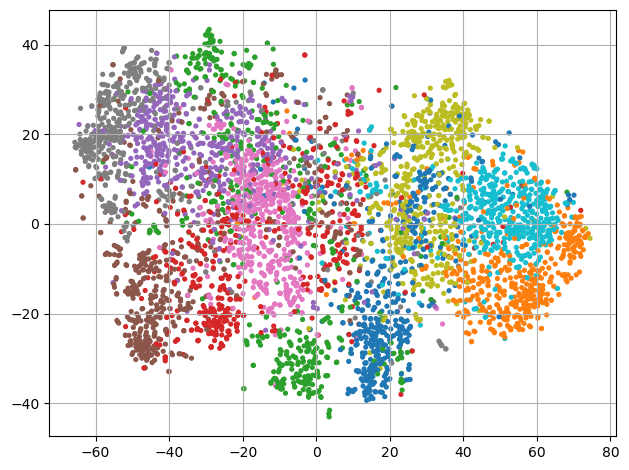

In [6]:
fig, axes = gen_tsne_plot(all_features, all_labels)